In [1]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import io
import base64
import tempfile
from IPython.display import HTML
from numpy import loadtxt

from controller_utils import CartpoleDx, sample_initial_signal, WeightClipper, episode_loss
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost
import mpc.util as eutil
from controllers import DDeePC

%matplotlib inline


/opt/conda/envs/deepc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Collection


In [2]:
Tini = 4
m = 1
p = 4
Tf = 25
T = (m+1)*(Tini + Tf + p) + 4
n_batch = 40
device = 'cuda' if torch.cuda.is_available() else 'mps'
# device = 'cpu'
print(device)
ud = loadtxt('../badcartpole_ud.csv', delimiter=',')
yd = loadtxt('../badcartpole_yd.csv', delimiter=',')
yd = yd.reshape(T*p,)
noise =  np.random.randn(*yd.shape)*0.001
noiseu =  np.random.randn(*ud.shape)*0.01
yd = yd + noise
ud = ud + noiseu
dx = CartpoleDx().to(device)
clipper = WeightClipper()
def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

cuda


In [3]:
u_constraints = np.ones(Tf)*4
y_constraints = np.kron(np.ones(Tf), np.array([0.25, 0.2, 0.15, 0.2]))
r = torch.ones(m)*0.01
q = torch.ones(p)*100 
q = torch.Tensor([100,10,100,10])
lam_g1 = torch.Tensor([500.409]).to(device)
lam_g2 = torch.Tensor([0.01]).to(device)
lam_y = torch.Tensor([210.258]).to(device)

controller = DDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, T=T, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic=True, q=q, r=r, lam_g2=lam_g2
).to(device)

/opt/conda/envs/deepc/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:209: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


In [4]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([20.0047], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([20.0109], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([20.0059], device='cuda:0', requires_grad=True)


In [5]:
episodes = 20
ref = torch.zeros(size=(n_batch,p))
perfect = torch.kron(torch.ones(episodes+Tini), ref).to(device)
ref = torch.kron(torch.ones(Tf), ref).to(device)
n_row = np.sqrt(n_batch).astype(np.uint8)
n_col = n_row
opt = torch.optim.Rprop(controller.parameters(), lr=0.01, step_sizes=(1e-3,100))
# opt = torch.optim.Adam(controller.parameters(), lr=1)

epochs = 100
pbar = tqdm(range(epochs))
cum_loss = []
done = False
I, PI = controller.get_PI()
PI = torch.Tensor(I-PI).to(device)

for j in pbar:
                                                                                                                                        
    uini = (torch.zeros(size=(n_batch, Tini*m)) + torch.randn(n_batch, Tini*m)*0.001).to(device)
    zero = torch.zeros(n_batch)
    th = uniform((n_batch), -0.01, 0.01)
    yini = torch.stack((zero, zero, th, zero), dim=1).repeat(1,Tini)
    y = yini[:,-p:].to(device)
    yini += torch.randn(yini.shape)*0.001
    yini = yini.to(device)
    traj = yini
    G, Ey, Eu, Y, U = torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device), torch.Tensor().to(device)
    
    for i in range(episodes):
        
        g, u_pred, _, sig_y, sig_u = controller(ref=ref, y_ini=yini, u_ini=uini)
        
        G, Ey, Eu = torch.cat((G, g.unsqueeze(1)), axis=1), torch.cat((Ey, sig_y.unsqueeze(1)), axis=1), torch.cat((Eu, sig_u.unsqueeze(1)), axis=1)
        input = u_pred[:,:m] 
        U = torch.cat((U, input.unsqueeze(1)), axis=1)
        y = dx(y, input)
        Y = torch.cat((Y, y.unsqueeze(1)), axis=1)
       
        noise = torch.randn(y.shape).to(device)*0.001
        y += noise
       
        yini = torch.cat((yini[:, p:], y), axis=1)
        uini = torch.cat((uini[:, m:], input + torch.randn(u_pred[:,:m].shape).to(device)*0.01), axis=1)
 
    loss = episode_loss(G=G, U=U, Y=Y, Ey=Ey, Eu=Eu, controller=controller, PI=PI)
    cum_loss.append(loss.item())
    opt.zero_grad()   
    loss.backward()
    opt.step()
    controller.apply(clipper)

    pbar.set_description(f'l={loss.item():.3f}, ly={controller.lam_y.data.item():.3f},\
l1={controller.lam_g1.data.item():.3f}, l2={controller.lam_g2.data.item():.3f}, lu={controller.lam_u.data.item():.3f}')

  0%|          | 0/100 [00:00<?, ?it/s]/root/michael/differentiable-deepc/src/controller_utils.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  Ct += (Y[i,j,:].T @ Q @ Y[i,j,:] + U[i,j,:].T @ R @ U[i,j,:]).reshape(1)
l=2.974, ly=20.018,l1=19.684, l2=0.010, lu=19.689:  11%|█         | 11/100 [07:55<1:02:13, 41.95s/it]

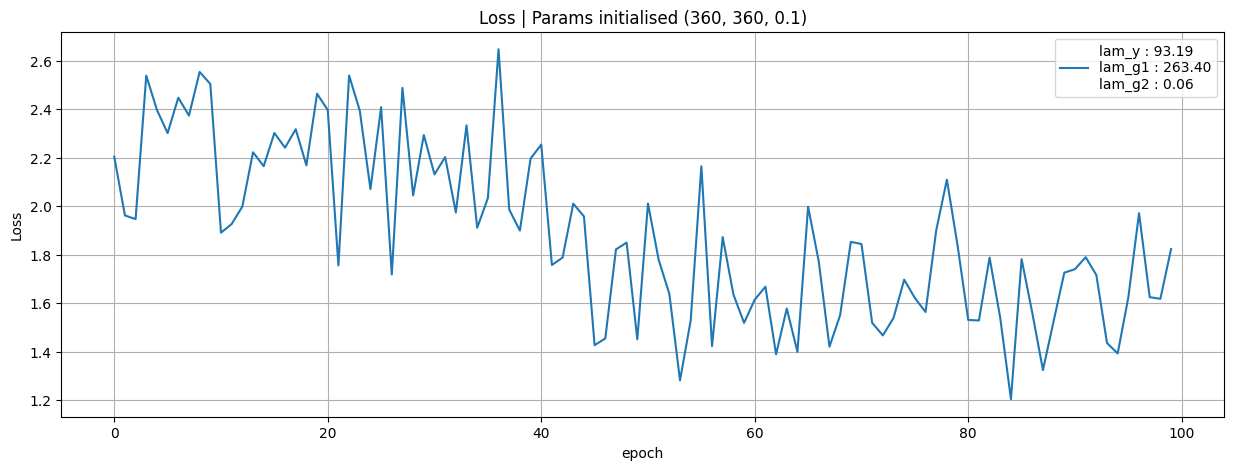

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
# plt.subplot(1,2,1)
plt.title(f'Loss | Params initialised (360, 360, 0.1)')
plt.plot(range(len(cum_loss)), cum_loss, label=f'lam_y : {controller.lam_y.data.item():.2f}\nlam_g1 : {controller.lam_g1.data.item():.2f}\nlam_g2 : {controller.lam_g2.data.item():.2f}')
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid('on')
plt.legend()
# plt.subplot(1,2,2)
# plt.title('Evolution of loss magnified from epoch 35 - 200')
# plt.plot(range(len(cum_loss[35:])), cum_loss[35:])
# plt.ylabel("Loss")
# plt.xlabel("epoch")
# plt.grid('on')
# plt.savefig(f'cartpole_{n_batch}_{episodes}.png')
plt.show()

In [ ]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([93.1931], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([263.3954], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0572], device='cuda:0', requires_grad=True)


In [ ]:
# vid_fname = 'cartpole.mp4'
# # if os.path.exists(vid_fname):
# #     os.remove(vid_fname)
# cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p {}'.format(
#     t_dir, vid_fname
# )
# os.system(cmd)
# # print('Saving video to: {}'.format(vid_fname))

# video = io.open(vid_fname, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))